In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False
)


In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
def train_model(model, loader, epochs=5):
    model.train()
    train_acc = []
    train_loss = []

    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100 * correct / total
        train_acc.append(acc)
        train_loss.append(running_loss)

        print(f"Epoch {epoch+1}: Loss = {running_loss:.2f}, Accuracy = {acc:.2f}%")

    return train_acc, train_loss


In [7]:
train_accuracy, train_loss = train_model(model, trainloader, epochs=5)


Epoch 1: Loss = 1282.50, Accuracy = 41.74%
Epoch 2: Loss = 1116.50, Accuracy = 49.48%
Epoch 3: Loss = 1028.54, Accuracy = 53.50%
Epoch 4: Loss = 955.76, Accuracy = 56.62%
Epoch 5: Loss = 892.90, Accuracy = 59.67%


In [8]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy = {accuracy:.2f}%")


In [9]:
evaluate_model(model, testloader)


Test Accuracy = 51.84%


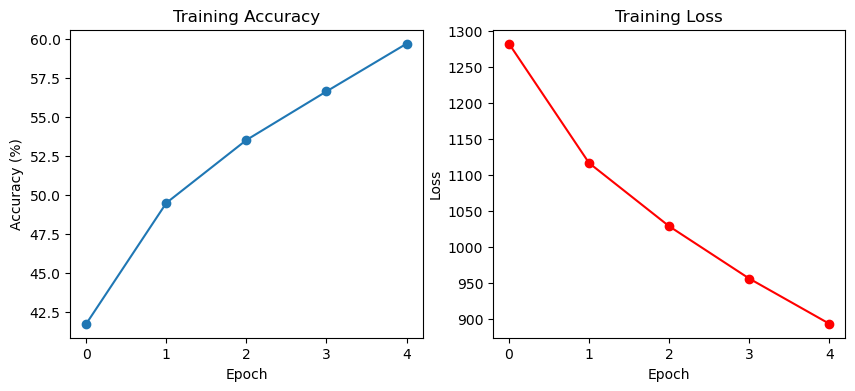

In [10]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_accuracy, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")

plt.subplot(1,2,2)
plt.plot(train_loss, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.show()


In [11]:
torch.save(model.state_dict(), "simplenn_cifar10.pth")
